In [8]:
import pyspark
from pyspark.sql import SparkSession
import pandas as pd
import re
from pyspark.sql.functions import col
from pyspark.sql.functions import lit
from pyspark.sql.functions import year, month, dayofmonth
from pyspark.sql.functions import regexp_extract
import matplotlib.pyplot as plt


In [2]:
spark = SparkSession.builder.appName('ks_geolog_spark').getOrCreate()

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/03/01 17:32:43 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [3]:
spark

In [4]:
data_path = 'data/'

csv_paths = [
    data_path+"Norway-Statoil-NO 15_$47$_9-F-1 C 0 time.csv",
    data_path+"Norway-Statoil-NO 15_$47$_9-F-11 time.csv",
    data_path+"Norway-Statoil-NO 15_$47$_9-F-5 time.csv",
    data_path+"Norway-Statoil-NO 15_$47$_9-F-7 time.csv",
    data_path+"Norway-Statoil-NO 15_$47$_9-F-4 time.csv"
]

# regex_pattern = r'^The mnemonic of the index$'


dfs = []
dfs_filtered= []
columns_to_filter = ['The mnemonic of the index curve ']

for path in csv_paths:
    df = spark.read \
                .option("header", "true") \
                .option("inferSchema", "true") \
                .csv(path)
    dfs.append(df)


24/03/01 17:32:58 WARN GarbageCollectionMetrics: To enable non-built-in garbage collector(s) List(G1 Concurrent GC), users should configure it(them) to spark.eventLog.gcMetrics.youngGenerationGarbageCollectors or spark.eventLog.gcMetrics.oldGenerationGarbageCollectors


In [5]:
for i in range(len(dfs)):
    dfs[i] = dfs[i].withColumnRenamed(dfs[i].columns[1], 'date_time')

In [6]:

columns_to_select = ["date_time","nameWellbore", "Mud Flow In m3/s", "Mud Flow Out m3/s", "Trip Expected Fill m3", "Trip Actual Fill Volume (m3)"]

for i in range(len(dfs)):
    # Check if each column exists in the current DataFrame
    for column in columns_to_select:
        if column not in dfs[i].columns:
            # If the column doesn't exist, add it with null values
            dfs[i] = dfs[i].withColumn(column, lit(None).cast("double"))

    dfs[i] = dfs[i].withColumn("year", year("date_time")) \
           .withColumn("month", month("date_time")) \
           .withColumn("day", dayofmonth("date_time")) \
           .withColumn("nameWellbore", regexp_extract(col("nameWellbore"), r'^.*(F-\d+)', 1))
           


# Select the desired columns from each DataFrame
df_filtered = [df.select(*columns_to_select, "year", "month", "day") for df in dfs]

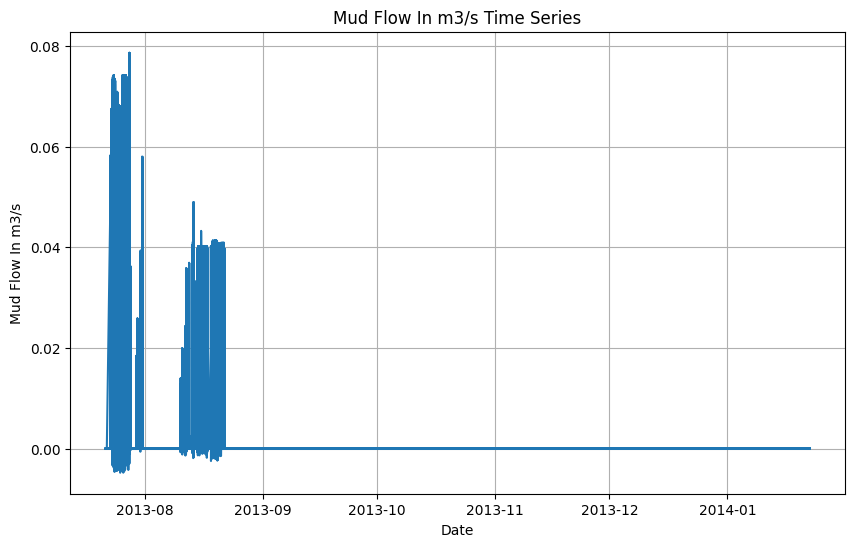

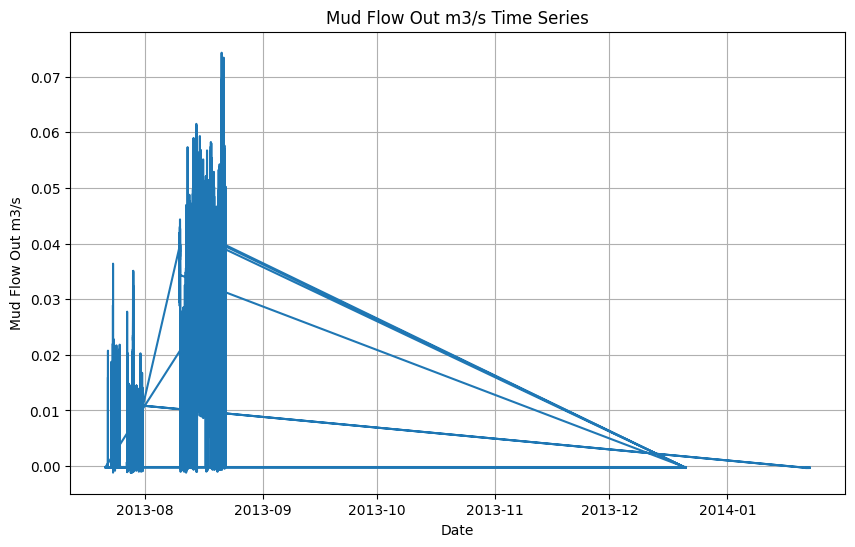

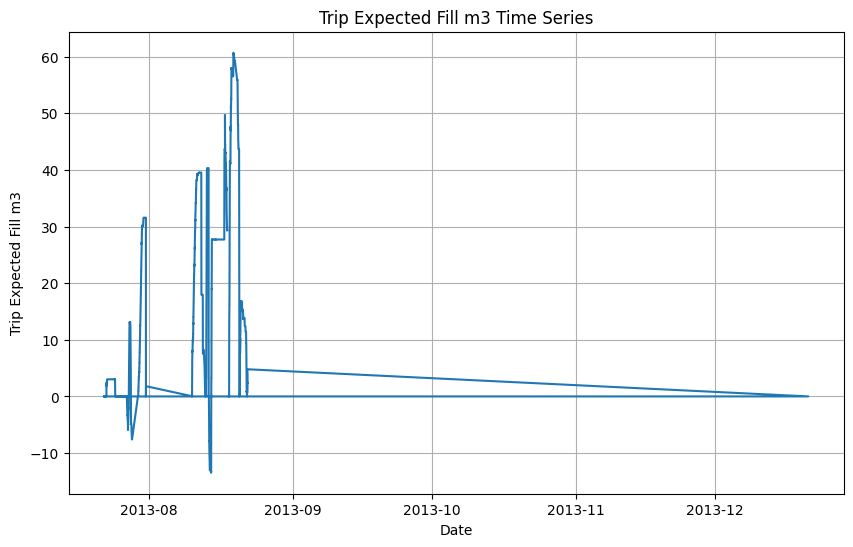

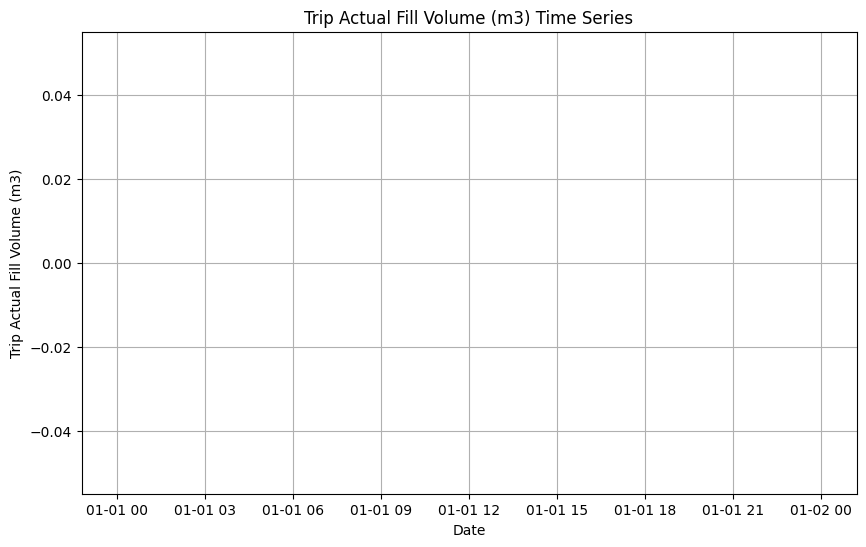

In [9]:
for column in ["Mud Flow In m3/s", "Mud Flow Out m3/s", "Trip Expected Fill m3", "Trip Actual Fill Volume (m3)"]:
    # Select the column and convert it to Pandas DataFrame for plotting
    data = df_filtered[0].select("date_time", column).toPandas()
    
    # Convert 'date_time' column to datetime type
    data['date_time'] = pd.to_datetime(data['date_time'])
    
    # Set 'date_time' as index
    data.set_index('date_time', inplace=True)
    
    # Plot the time series
    plt.figure(figsize=(10, 6))
    plt.plot(data.index, data[column])
    plt.title(column + " Time Series")
    plt.xlabel("Date")
    plt.ylabel(column)
    plt.grid(True)
    plt.show()